In [ ]:
# Import Libraries
import torch
from torch import nn, optim

# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import Others
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm.auto import tqdm
import random

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Load CIFAR-10
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


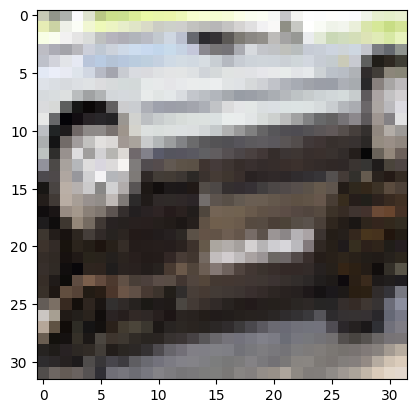

In [ ]:
rand_image = random.randint(0, 64-1)
image_np = images[rand_image].cpu().numpy().transpose((1, 2, 0))

plt.imshow(image_np)
plt.show()

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class CIFARModelV0(nn.Module):
    def __init__(self):
        super(CIFARModelV0, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
model_0 = CIFARModelV0().to(device)
model_0

CIFARModelV0(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
def train_test_loop(epochs, model):
  train_time_start_on_cpu = timer()
  for e in tqdm(range(epochs)):
    train_loss = 0
    for batch, (images, labels) in enumerate(train_loader):

      # Put on Target Device
      images, labels = images.to(device), labels.to(device)

      # Flatten MNIST images into a 784 long vector
      #images = images.view(images.shape[0], -1)

      # Forward Pass
      image_prediction = model(images)

      # Calculate Loss
      loss = loss_fn(image_prediction, labels)
      train_loss += loss_fn(image_prediction, labels)

      # Optimizer Zero Grad
      optimizer.zero_grad()

      # Loss Backward
      loss.backward()

      # Optimizer Step
      optimizer.step()

      # Printing
      if batch % 200 == 0:
        print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples.")

    train_loss /= len(train_loader)

    # Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
      for images_test, labels_test in test_loader:

        # Put on Target Device
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        # Flatten MNIST images into a 784 long vector
        #images_test = images_test.view(images_test.shape[0], -1)

        # 1. Forward Pass
        test_prediction = model(images_test)

        # 2. Calculate Loss
        test_loss += loss_fn(test_prediction, labels_test)

        # 3. Calculate Accuracy
        test_acc += accuracy_fn(y_true=labels_test, y_pred=test_prediction.argmax(dim=1))

      # Calculate the test loss and accuracy averages
      test_loss /= len(test_loader)
      test_acc /= len(test_loader)

    # Printing
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  # Calculate training time
  train_time_end_on_cpu = timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


In [ ]:
epochs = 20
model = model_0

train_test_loop(epochs, model)

  0%|          | 0/20 [00:00<?, ?it/s]

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked at 38400/50000 samples.

Train loss: 1.93122 | Test loss: 1.84767, Test acc: 33.25%

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked at 38400/50000 samples.

Train loss: 1.42737 | Test loss: 1.49215, Test acc: 46.36%

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked at 38400/50000 samples.

Train loss: 1.18227 | Test loss: 1.38359, Test acc: 50.75%

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked at 38400/50000 samples.

Train loss: 0.98588 | Test loss: 0.99461, Test acc: 65.39%

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked at 38400/50000 samples.

Train loss: 0.83077 | Test loss: 1.06460, Test acc: 63.50%

Looked at 0/50000 samples.
Looked at 12800/50000 samples.
Looked at 25600/50000 samples.
Looked

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward Pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU to further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
k = 9

import random
#random.seed(32)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([3, 32, 32])

In [ ]:
len(test_samples)

9

In [ ]:
# Make Predictions
pred_probs = make_predictions(model=model_0,
                             data=test_samples)

# View the first two prediction probabilities
pred_probs[:2]

tensor([[8.3180e-04, 1.6596e-05, 4.7733e-04, 9.9445e-01, 4.1473e-06, 2.6071e-03,
         1.5996e-03, 1.3246e-07, 1.5814e-05, 7.8214e-07],
        [3.0207e-11, 1.6887e-10, 3.2713e-03, 1.3138e-06, 9.9671e-01, 7.8914e-07,
         1.9534e-05, 2.4092e-10, 2.1367e-10, 7.9515e-12]])

The actual class is: frog


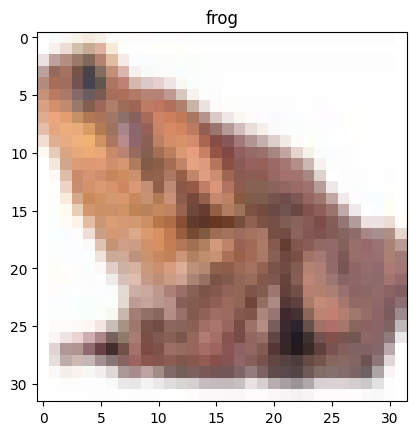

In [ ]:
r = random.randint(1, k-1)
item = test_labels[r]

plt.imshow(test_samples[r].cpu().numpy().transpose((1, 2, 0)), cmap="gray");
plt.title(class_names[test_labels[r]]);
print("The actual class is:", class_names[item])

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 4, 1, 6, 0, 8, 6, 4, 6])

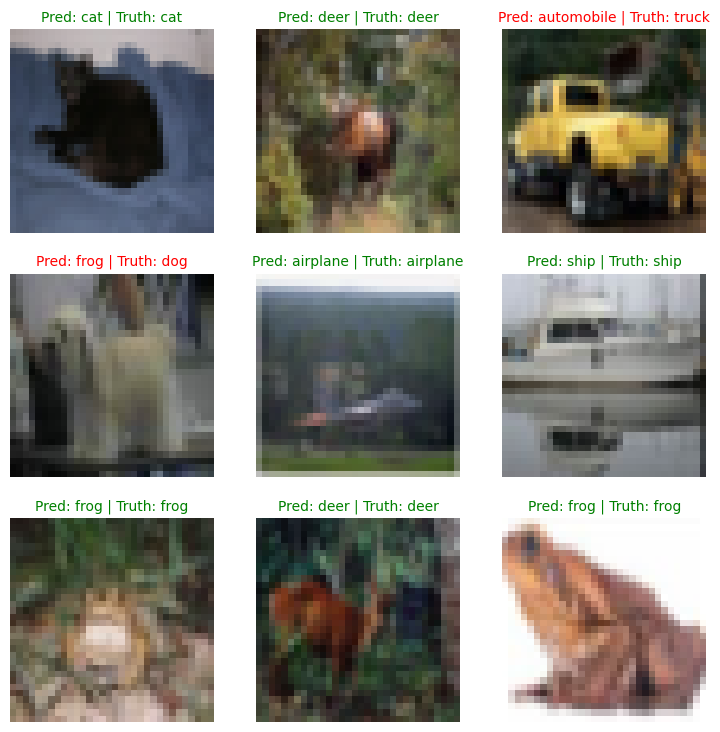

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.cpu().numpy().transpose((1, 2, 0)), cmap="gray")

  # Find the prediction in text form
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title color accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);